In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [2]:
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ANSI')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [3]:
import zipfile
zip_file = "zippedData/im.db.zip"
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("zippedData/unZippedim.db")
        print("Extracted all")
except:
    print("Invalid file")

conn = sqlite3.connect("zippedData/unZippedim.db/im.db")

Extracted all


In [4]:
movie_info.rename(columns={'currency':'currency_dollars'}, inplace=True)
movie_info['currency_dollars'].fillna(False, inplace=True)
movie_info.loc[movie_info['currency_dollars'] == '$', 'currency_dollars'] = True

In [5]:
# Change objects to floats

# bom['foreign_gross'] = bom['foreign_gross'].str.replace(',','')
# bom['foreign_gross'] = bom["foreign_gross"].astype("float64")

movie_info['runtime'] = movie_info['runtime'].str.replace(' minutes','')
movie_info['runtime'] = movie_info['runtime'].astype("float64")


In [6]:
reviews['rating'].unique()

array(['3/5', nan, 'C', '2/5', 'B-', '2/4', 'B', '3/4', '4/5', '4/4',
       '6/10', '1/4', '8', '2.5/4', '4/10', '2.0/5', '3/10', '7/10', 'A-',
       '5/5', 'F', '3.5/4', 'D+', '1.5/4', '3.5/5', '8/10', 'B+', '9/10',
       '2.5/5', '7.5/10', '5.5/10', 'C-', '1.5/5', '1/5', '5/10', 'C+',
       '0/5', '6', '0.5/4', 'D', '3.1/5', '3/6', '4.5/5', '0/4', '2/10',
       'D-', '7', '1/10', '3', 'A+', 'A', '4.0/4', '9.5/10', '2.5',
       '2.1/2', '6.5/10', '3.7/5', '8.4/10', '9', '1', '7.2/10', '2.2/5',
       '0.5/10', '5', '0', '2', '4.5', '7.7', '5.0/5', '8.5/10', '3.0/5',
       '0.5/5', '1.5/10', '3.0/4', '2.3/10', '4.5/10', '4/6', '3.5',
       '8.6/10', '6/8', '2.0/4', '2.7', '4.2/10', '5.8', '4', '7.1/10',
       '5/4', 'N', '3.5/10', '5.8/10', 'R', '4.0/5', '0/10', '5.0/10',
       '5.9/10', '2.4/5', '1.9/5', '4.9', '7.4/10', '1.5', '2.3/4',
       '8.8/10', '4.0/10', '2.2', '3.8/10', '6.8/10', '7.3', '7.0/10',
       '3.2', '4.2', '8.4', '5.5/5', '6.3/10', '7.6/10', '8.1/10',
  

## Approach

We will clean the ratings column, split it into two new columns "num_of_stars" and "out_of_stars", and create a third column 'rating_out_of_10' containing the quotient - a normalized percentage rating.

We will make the following modifications to the ratings column:
- We will be changing all letter "grades" to numerical scores out of 10, evenly distributed between 0 and 10.
    - Note that F+ and F- will be grouped with F.
- We will be replacing all NaN ratings, ratings out of 2, all ratings without an "out-of" denominator, and any other nonsensical ratings with '-1/1'. This will allow us to split all ratings by the '/' character before calculating ratings out of 10; upon creating the new columns we will go back and reset all '-1/1' values to NaN.

In [7]:
import numpy as np

# Change letter ratings to numerical (out of 10)
reviews['rating'].replace('F+', 'F', inplace=True)
reviews['rating'].replace('F-', 'F', inplace=True)

letter_ratings = ['A+','A','A-','B+','B','B-','C+','C','C-','D+','D','D-','F']
nums = list(np.round(np.linspace(0,10, 13), 1))
num_ratings = [f'{str(num)}/10' for num in nums]
mapping = dict(zip(letter_ratings, num_ratings))

for rating in letter_ratings:
    reviews.replace(rating, mapping[rating], inplace=True)

reviews['rating'].fillna('-1/1', inplace=True)
    
# # Remove all ratings that do not contain '/'
for rating in reviews['rating'].unique():
    if "/" not in rating:
        reviews['rating'].replace(rating, '-1/1', inplace=True)

# Remove other nonsensical ratings
reviews['rating'].replace('R', '-1/1', inplace=True)
reviews['rating'].replace('N', '-1/1', inplace=True)
reviews['rating'].replace('T', '-1/1', inplace=True)

reviews['rating'].replace('1/2', '-1/1', inplace=True)
reviews['rating'].replace('2/2', '-1/1', inplace=True)
reviews['rating'].replace('3/2', '-1/1', inplace=True)
reviews['rating'].replace('3 1/2', '-1/1', inplace=True)
reviews['rating'].replace('1-5', '-1/1', inplace=True)
reviews['rating'].replace('5/4', '-1/1', inplace=True)
reviews['rating'].replace('2.1/2', '-1/1', inplace=True)



In [8]:
reviews['rating'].unique()

array(['3/5', '-1/1', '5.8/10', '2/5', '4.2/10', '2/4', '3.3/10', '3/4',
       '4/5', '4/4', '6/10', '1/4', '2.5/4', '4/10', '2.0/5', '3/10',
       '7/10', '1.7/10', '5/5', '10.0/10', '3.5/4', '7.5/10', '1.5/4',
       '3.5/5', '8/10', '2.5/10', '9/10', '2.5/5', '5.5/10', '6.7/10',
       '1.5/5', '1/5', '5/10', '5.0/10', '0/5', '0.5/4', '8.3/10',
       '3.1/5', '3/6', '4.5/5', '0/4', '2/10', '9.2/10', '1/10', '0.0/10',
       '0.8/10', '4.0/4', '9.5/10', '6.5/10', '3.7/5', '8.4/10', '7.2/10',
       '2.2/5', '0.5/10', '5.0/5', '8.5/10', '3.0/5', '0.5/5', '1.5/10',
       '3.0/4', '2.3/10', '4.5/10', '4/6', '8.6/10', '6/8', '2.0/4',
       '7.1/10', '3.5/10', '4.0/5', '0/10', '5.9/10', '2.4/5', '1.9/5',
       '7.4/10', '2.3/4', '8.8/10', '4.0/10', '3.8/10', '6.8/10',
       '7.0/10', '5.5/5', '6.3/10', '7.6/10', '8.1/10', '3.6/5', '2/6',
       '7.7/10', '8.9/10', '8.2/10', '2.6/6', '4.1/10', '6.0/10', '1.0/4',
       '7.9/10', '8.7/10', '4.3/10', '9.6/10', '9.0/10', '8.0/10',
    

In [10]:
reviews['num_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[0]))
reviews['out_of_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[1]))
reviews['rating_out_of_10'] = reviews['num_stars'] / reviews['out_of_stars'] * 10
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,It's an allegory in search of a meaning that n...,-1/1,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",-1.0,1.0,-10.0
2,3,... life lived in a bubble in financial dealin...,-1/1,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",-1.0,1.0,-10.0
3,3,Continuing along a line introduced in last yea...,-1/1,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",-1.0,1.0,-10.0
4,3,... a perverse twist on neorealism...,-1/1,fresh,NaN,0,Cinema Scope,"October 12, 2017",-1.0,1.0,-10.0


In [11]:
reviews['rating'].replace('-1/1', np.nan, inplace=True)
reviews['num_stars'].replace(-1.0, np.nan, inplace=True)
reviews['out_of_stars'].replace(1.0, np.nan, inplace=True)
reviews['rating_out_of_10'].replace(-10.0, np.nan, inplace=True)

In [13]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",NaN,NaN,NaN
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",NaN,NaN,NaN
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",NaN,NaN,NaN
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",NaN,NaN,NaN


In [14]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                54432 non-null  int64  
 1   review            48869 non-null  object 
 2   rating            40141 non-null  object 
 3   fresh             54432 non-null  object 
 4   critic            51710 non-null  object 
 5   top_critic        54432 non-null  int64  
 6   publisher         54123 non-null  object 
 7   date              54432 non-null  object 
 8   num_stars         40141 non-null  float64
 9   out_of_stars      40141 non-null  float64
 10  rating_out_of_10  40141 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 4.6+ MB


In [15]:
reviews.loc[reviews['rating'].isna() == False].head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
6,3,"Quickly grows repetitive and tiresome, meander...",5.8/10,rotten,Eric D. Snider,0,EricDSnider.com,"July 17, 2013",5.8,10.0,5.8
7,3,Cronenberg is not a director to be daunted by ...,2/5,rotten,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013",2.0,5.0,4.0
11,3,"While not one of Cronenberg's stronger films, ...",4.2/10,fresh,Emanuel Levy,0,EmanuelLevy.Com,"February 3, 2013",4.2,10.0,4.2
12,3,Robert Pattinson works mighty hard to make Cos...,2/4,rotten,Christian Toto,0,Big Hollywood,"January 15, 2013",2.0,4.0,5.0


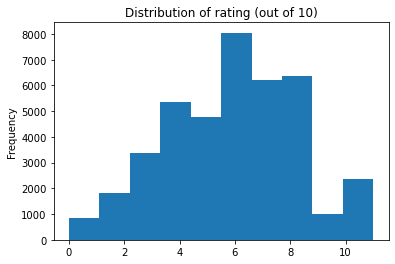

In [16]:
reviews['rating_out_of_10'].plot(kind='hist', title='Distribution of rating (out of 10)');

In [17]:
reviews['rating_out_of_10'].mean()

5.917284073640418

In [18]:
reviews['rating_out_of_10'].median()

6.0

In [19]:
reviews['rating_out_of_10'].mode()

0    6.0
dtype: float64

In [20]:
reviews.groupby('fresh')['id'].count()

fresh
fresh     33035
rotten    21397
Name: id, dtype: int64

In [21]:
pd.read_sql("""
SELECT * FROM movie_ratings
LIMIT 10;
""", conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
5,tt1069246,6.2,326
6,tt1094666,7.0,1613
7,tt1130982,6.4,571
8,tt1156528,7.2,265
9,tt1161457,4.2,148
